<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Catherine Benavides
- Nombre de alumno 2: Fernanda Saavedra


### **Link de repositorio de GitHub:** https://github.com/FernandaSD/MDS7202

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

## 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [ ]:
!pip install xgboost
!pip install shap
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.5 MB/s eta 0:00:00


In [ ]:
# Librerías
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from alibi.explainers import AnchorTabular

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [ ]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


In [ ]:
# Se carga la base
df = pd.read_csv('/content/drive/MyDrive/diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?.

In [ ]:
# Dimensiones del dataframe
df.shape

(70692, 18)

In [ ]:
# Se revisan datos faltantes
df.isna().sum()

Age                     0
Sex                     0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Stroke                  0
HighBP                  0
Diabetes                0
dtype: int64

In [ ]:
# Se revisan datos duplicados
df.duplicated().sum()

6672

Se puede observar que el dataset no cuenta con datos faltantes, pero sí tienen registros duplicados, los cuales son eliminados.

In [ ]:
# Se eliminan datos duplicados
df = df.drop_duplicates(keep='first')

In [ ]:
# Descripción de variables numéricas
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000
mean,8.607420,0.455983,0.539550,0.973211,30.178554,0.490706,0.159950,0.678366,0.590862,0.771587,0.046345,2.921103,4.130537,6.385020,0.277007,0.068510,0.581756,0.521681
std,2.860717,0.498063,0.498437,0.161466,7.287730,0.499918,0.366563,0.467107,0.491679,0.419813,0.210233,1.107991,8.466301,10.368493,0.447524,0.252621,0.493275,0.499534
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,11.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,7.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Cantidad de valores únicos por columna
df.nunique()

Age                     13
Sex                      2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Stroke                   2
HighBP                   2
Diabetes                 2
dtype: int64

In [ ]:
# Balance de las clases (Diabetes)
balance = df[df['Diabetes'] == 1]
balance.shape

(33398, 18)

In [ ]:
# Balance de las clases (Sin diabetes)
balance = df[df['Diabetes'] == 0]
balance.shape

(30622, 18)

Con respecto al balence de las clases, se puede observar que si bien no están completamente balanceadas, la diferencia entre ambas no es muy grande.

Una vez revisados los datos, se contruye el Column Transformer. La base cuenta solamente con datos numéricos, donde la mayoría son de tipo binario. Para estas últimas, se utilizará passthrough ya que no necesitan ser transformadas. Para el resto de variables se utilizará MinMaxScaler para mantener la distribución de los datos, ya que estos son las que contienen los patrones necesarios para hacer la clasificación.

In [ ]:
# Datos Numéricos
num_cols = ['Age', 'BMI', 'MentHlth', 'PhysHlth', 'GenHlth']
num_transformer = MinMaxScaler()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_cols)],
    remainder='passthrough',
    sparse_threshold = 0)

A continuación, se contruye el pipeline que contiene al Column Transformer y al clasificador. Luego, se separan los datos y se entrena y evalua el modelo.

In [ ]:
# Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
 ('classifier', xgb.XGBClassifier(random_state = 0))])

In [ ]:
# Separación del dataset
X = df[['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP']]

y = df['Diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [ ]:
# Entrenamiento y métricas de evaluación
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71      9187
         1.0       0.72      0.79      0.75     10019

    accuracy                           0.73     19206
   macro avg       0.73      0.73      0.73     19206
weighted avg       0.73      0.73      0.73     19206



Se comenta que las métricas obtenidas para cada clase están balanceadas con la excepción del recall, donde se puede observar una mayor diferencia entre los resultados obtenidos para cada clase.

**¿Es acaso un buen predictor de diabetes?**

Si bien el modelo obtiene buenos resultados en cada una de las métricas, superando el umbral de 0.5, al ser un modelo que busca detectar enfermedades se hace necesario encontrar mejores métricas. En este caso particular, al tratarse de la diabetes se necesitan minimizar tanto los falsos negativos como los falsos positivos, ya que es perjudicial no tratar la enfermedad en caso de ser necesario y también administrar medicamentos a personas que no lo necesitan.

**¿Qué buscan explicar las métricas utilizadas?**

- El recall se refiere a la proporción de instancias positivas que son correctamente identificadas por el modelo. Un valor alto de recall indica que el modelo tiene una baja tasa de falsos negativos.

- La precisión es la proporción de instancias positivas correctamente clasificadas en relación con todas las instancias clasificadas como positivas. Un valor alto de precisión indica que el modelo tiene una baja tasa de falsos positivos.

- El F1-score es una medida que combina tanto el recall como la precisión en una única métrica. Es útil cuando hay un desequilibrio en las clases de datos. Proporciona una visión general del equilibrio entre la capacidad del modelo para encontrar ejemplos positivos y su capacidad para evitar falsos positivos.

**¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?**

Estas métricas no están directamente relacionadas con la selección de features del modelo, sólo buscan evaluar de su rendimiento en términos de la capacidad de clasificar correctamente las instancias positivas y negativas, pero no proporcionan información específica sobre qué características contribuyeron más al rendimiento del modelo.

## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [ ]:
# Nombre de cada feature de entrada
X.columns

Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP'],
      dtype='object')

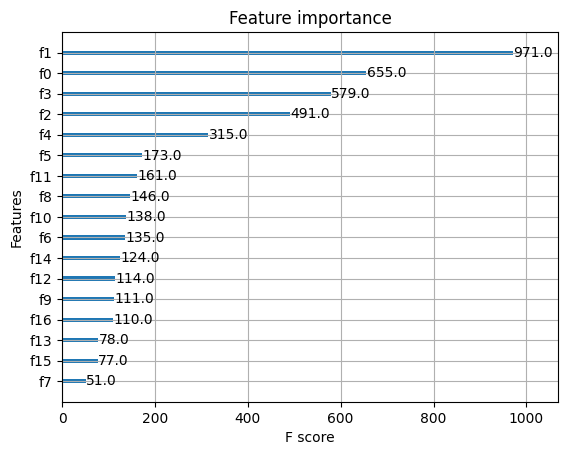

In [ ]:
# Importancia features con método weight
plot_importance(pipeline.named_steps['classifier'], importance_type = 'weight')
plt.show()

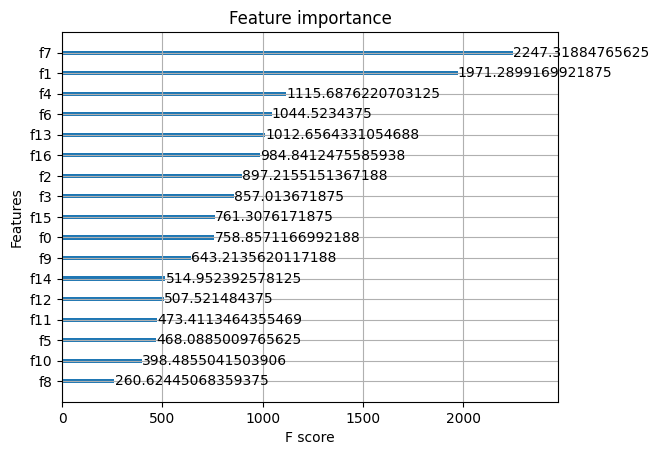

In [ ]:
# Importancia features con método cover
plot_importance(pipeline.named_steps['classifier'], importance_type = 'cover')
plt.show()

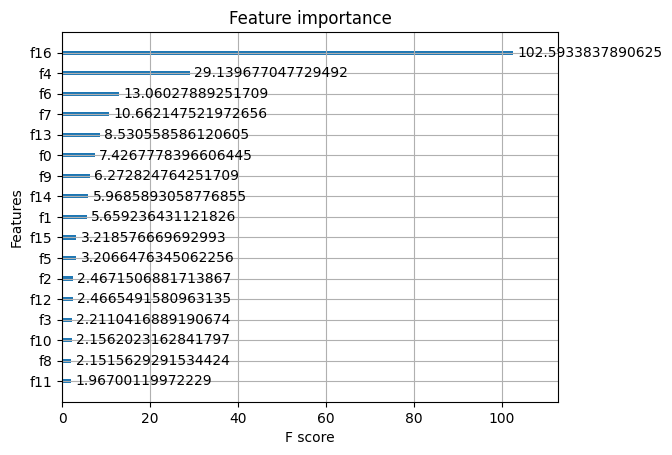

In [ ]:
# Importancia features con método gain
plot_importance(pipeline.named_steps['classifier'], importance_type = 'gain')
plt.show()

**¿Los resultados obtenidos con los diferentes métodos son compatibles? Comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados.**

Se puede observar que se obtienen resultados diferentes según el método utilizado. De hecho, para weight 'f7' es la última feature en términos de importancia, pero cover la deja en el primer puesto.

Esta diferencia en los resultados se puede deber a que cada uno de los métodos evalúa la importancia de las características desde una perspectiva diferente. El método "weight" se basa en la frecuencia de uso de una característica, el método "cover" considera la cantidad de muestras afectadas por las divisiones y el método "gain" evalúa la mejora en la precisión del modelo.

**¿Las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles?**

No son suficientes, ya que cada gráfico mustra resultados diferentes. Sin embargo, si se analiza cada gráfico por separado se ven claras distintinciones en la importancia de las variables (alta variabilidad).

**¿Qué debilidad presenta este método?**

Estos métodos no tienen en cuenta la correlación entre las variables, pudiendo asignar una alta importancia a características que están muy correlacionadas con otras, cuando en verdad puede ser redundante y no aportar información adicional al modelo. Además, si una característica está dominada por un valor específico, puede tener una alta importancia según los métodos weigth o cover, aunque no aporte realmente información valiosa para la clasificación.


## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala esta?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [ ]:
# Método de permutación
result = permutation_importance(pipeline, X_test, y_test, n_repeats = 30,
                                random_state = 0)

# Se muestra el resultado
result

{'importances_mean': array([0.02669652, 0.00270054, 0.01121351, 0.00317436, 0.03112569,
        0.00119581, 0.00345725, 0.00074977, 0.00099622, 0.00097018,
        0.00447256, 0.05186921, 0.00050679, 0.0010344 , 0.00311708,
        0.00089382, 0.01657121]),
 'importances_std': array([0.00176992, 0.00067147, 0.0013281 , 0.00049202, 0.00217839,
        0.00052231, 0.00088213, 0.00071196, 0.00052132, 0.00064634,
        0.0006431 , 0.00202533, 0.00092272, 0.00093805, 0.00081849,
        0.00052621, 0.00151096]),
 'importances': array([[ 2.32219098e-02,  2.91575549e-02,  2.61897324e-02,
          2.82203478e-02,  2.75434760e-02,  2.51483911e-02,
          2.58252629e-02,  2.55649276e-02,  2.45756534e-02,
          2.86889514e-02,  2.57731959e-02,  2.71269395e-02,
          2.54087264e-02,  2.74393419e-02,  2.94699573e-02,
          2.57211288e-02,  2.61897324e-02,  2.82203478e-02,
          2.50963241e-02,  2.80641466e-02,  2.40549828e-02,
          2.95740914e-02,  2.36905134e-02,  2.5616

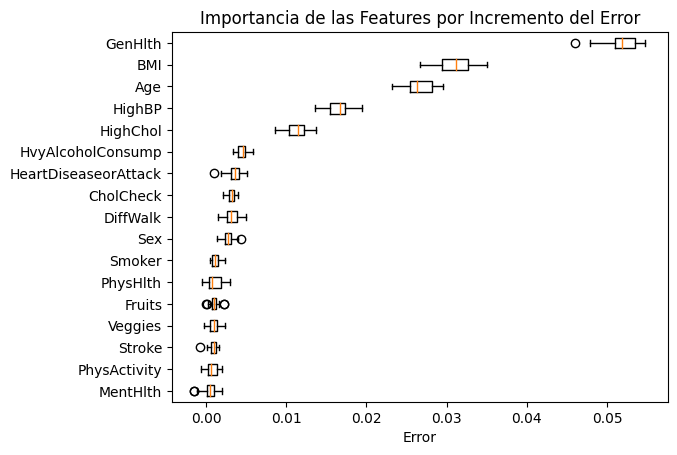

In [ ]:
# Se grafica la importancia de las variables
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False,
    labels=np.array(df.columns)[perm_sorted_idx])
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

**¿Cómo mide la importancia de las features su propuesta?**

Este método calcula el error del modelo original (e1). Luego, permuta la matriz de características (se rompe la asociación característica - resultado) y calcula nuevamente el error (e2), pero ahora con las predicciones obtenidas con la nueva matriz. Finalmente, se calcula la importancia de la característica permutada como el cociente entre e1 y e2.

**¿Qué features tienen un mayor impacto en la salida del modelo?**

Las features más importantes según el modelo son:

- GenHlth: Tiene sentido ya que se espera que las personas con índice saludable sean menos propensas a enfermedades como la diabetes.
- BMI: Tiene sentido ya que en general las personas con un BMI alto tienen sobrepeso u obesidad lo cual es un factor de riesgo para la diabetes.
- Age: Tiene sentido ya que las consecuencias (como la diabetes tipo 2) de una mala alimentación se ve en edades más tardías.
- HighBP: Las personas con diabetes tienden a desarrollar una alta presión arterial.
- HighChol: Puede ser indicio de una mala alimentación que puede traer como concecuencia a la diabetes.

**¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?**

En general, hay discrepancias entre las features más importantes segun los métodos de importance plot de XGBoost y el permutation plot. Con respecto a las variables más importantes según el permutation plot se comenta que:
- Gen health no aparece en el top 5 de ninguno de los métodos utilizados para importance plot.
- BMI aparece en el top 5 en todos los métodos de importance plot.
- Age solo aparece en el top 5 del método weight del importance plot al igual que HighChol.
- HighBP solo aparece en el top 5 del método gain del importance plot.

**Nombre y explique 3 ventajas y 3 desventajas del método implementado.**

El método de Permutation Feature Importance presenta varias ventajas y desventajas:

Ventajas:

1. Fácil interpretación: Cuanto mayor sea el incremento en el error después de permutar una característica, más importante se considera esa característica para el modelo.

2. Alta compresión de interpretabilidad global: El método proporciona una visión general de la importancia de las características en el modelo en su conjunto, lo que permite identificar las características más relevantes.

3. Comparabilidad con diferentes modelos: Este método se puede aplicar a diferentes tipos de modelos de ML, lo que facilita la comparación de la importancia de las características entre diferentes modelos.

Desventajas:

1. La importancia de las características se basa en el incremento del error del modelo después de realizar permutaciones entre ellas. Dado esto, si el modelo tiene un alto error de base, puede que las diferencias en la importancia de las características no sean tan relevantes.

2. Si las características están altamente correlacionadas, permutar una característica puede llevar a entradas poco realistas o incoherentes en los datos. Esto puede afectar la importancia percibida de las características y generar sesgos en la interpretación.

3. Si se agrega una característica altamente correlacionada con otra, la importancia de la característica original puede disminuir. Esto se debe a que la importancia se distribuye entre ambas características, lo que puede afectar la interpretación de la importancia individual de cada característica.

## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [ ]:
# Se calculan los shap values
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:

shap_values

.values =
array([[ 0.07518935,  1.7239242 ,  0.10729495, ...,  0.03700314,
         0.00698409,  0.68431515],
       [ 0.17914012, -0.36538872, -0.7049896 , ...,  0.15006478,
        -0.07898479,  0.52858925],
       [ 0.16268617,  0.62726444,  0.00686792, ...,  0.01004567,
         0.06208939, -0.78587526],
       ...,
       [-0.16984107, -1.7224833 , -0.11366875, ...,  0.06568062,
        -0.05508262,  0.4853718 ],
       [-0.14218818, -1.8463092 , -0.3883342 , ...,  0.14545293,
        -0.04925802,  0.480286  ],
       [-0.0420819 , -2.0114403 , -0.09087587, ..., -0.12399276,
        -0.02311514,  0.4743758 ]], dtype=float32)

.base_values =
array([0.0928494, 0.0928494, 0.0928494, ..., 0.0928494, 0.0928494,
       0.0928494], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.,  1.],
    

**¿Qué representa cada número en su resultado?**

- base_values: Representan el valor base. Este corresponde al valor esperado de la salide de nuestro modelo, para el caso que no se tuviera información en las variables explicativas. En este caso, se tiene que el valor base corresponde al promedio de las predicciones de la variable diabetes.

- values: Corresponden a los shap values. Estos muestran como contribuye una característica c/r al valor base. Esto se repite para cada una de las instancias del dataframe.

- data: Corresponde a la matriz de entrada del modelo.

**¿Es posible atribuir un significado a la positividad/negatividad de cada valor?**

Sí, dado que el signo de un Shap value indica el impacto que tiene esa característica con respecto al valor base. Si el shap value es positivo, la variable también tiene un impacto postivo c/r al valor base en la predicción.

### Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

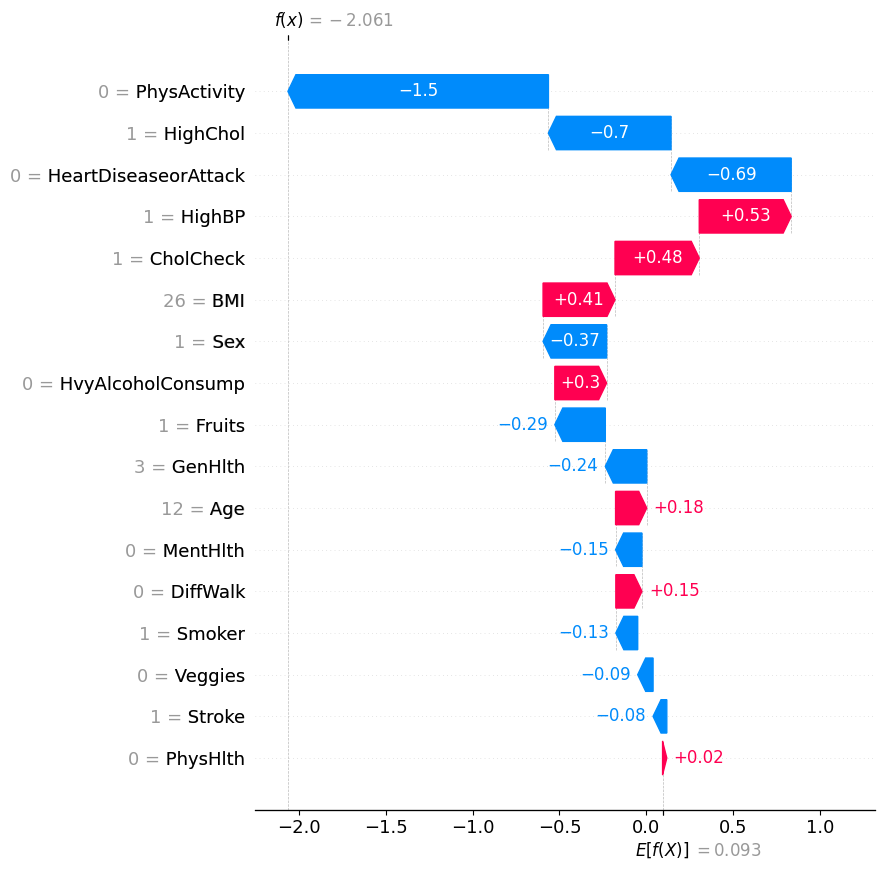

In [ ]:
# Aporte instancia 1
idx = 1
shap.plots.waterfall(shap_values[idx,:],
                     max_display=18)

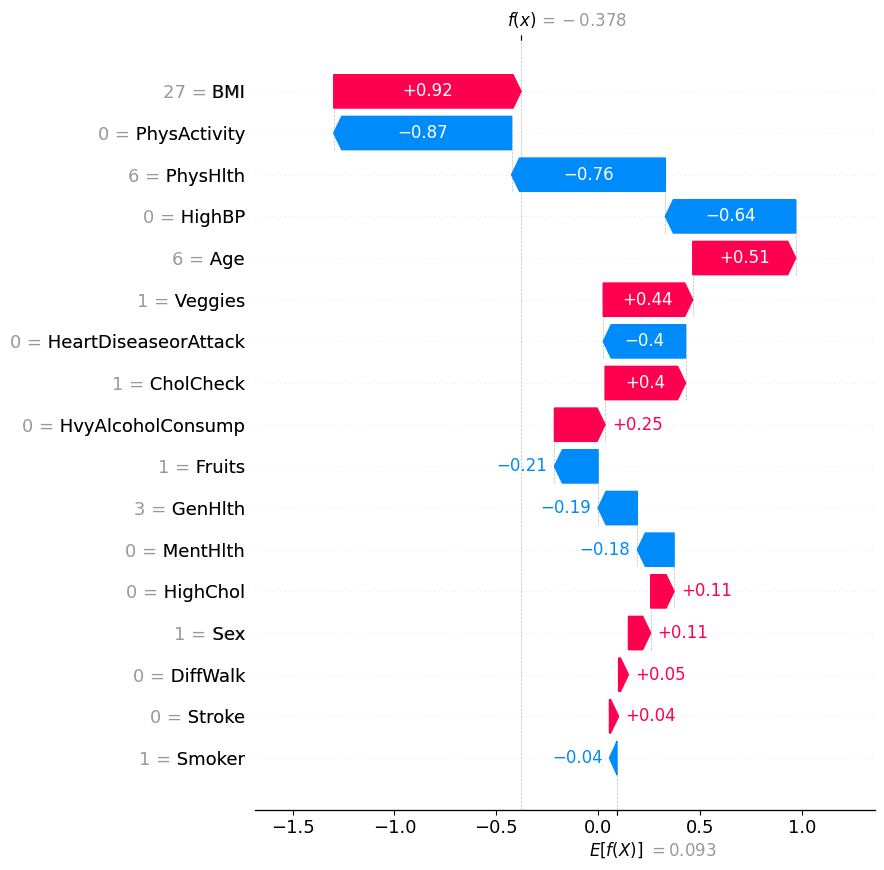

In [ ]:
# Aporte instancia 9
idx = 9
shap.plots.waterfall(shap_values[idx,:],
                     max_display=18)

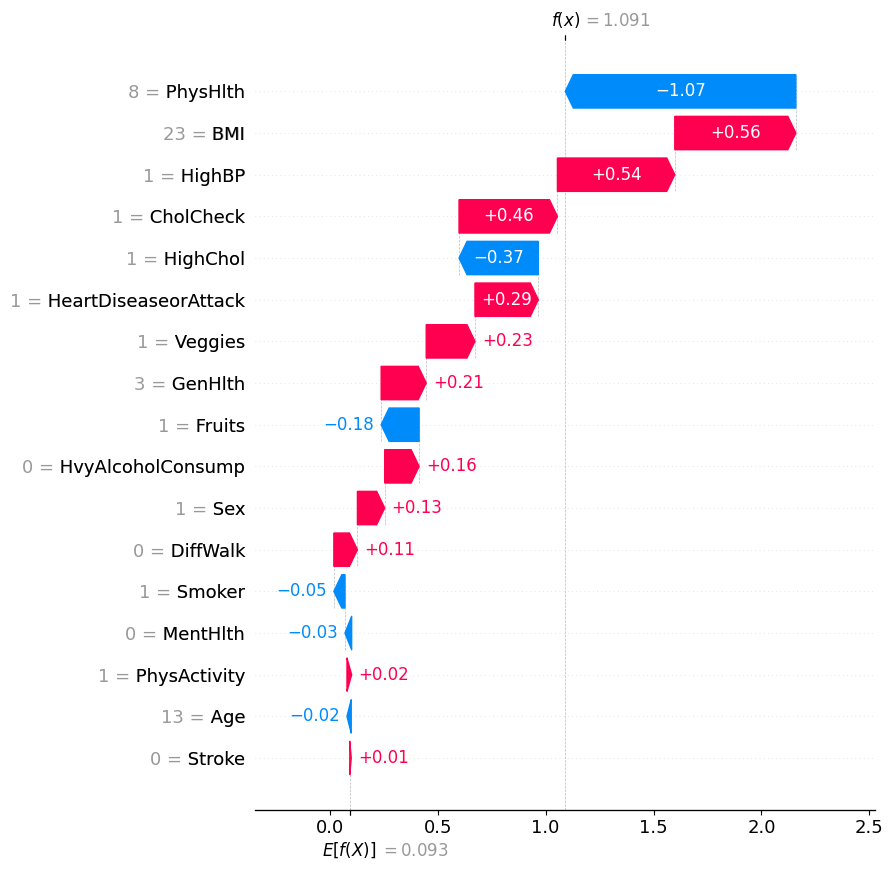

In [ ]:
# Aporte instancia 150
idx = 150
shap.plots.waterfall(shap_values[idx,:],
                     max_display=18)

**¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?**

De los gráficos se observa que hay variables que tienen un impacto positivo en la probabilidad de tener diabetes para las 3 instancias (1, 9 y 150). En esta categoria se encuentra: CholCheck, BMI, HvyAlcoholConsump, DiffWalk.

Por otro lado, hay variables que tienen un impacto positivo para 2 instancias, como es el caso de: HighBP (que es positiva para 1 y 150), Age (que es positiva para 1 y 9), Veggies, Sex, Stroke (que son positivas para 9 y 150).

A su vez, hay variables que sólo son positivas para una instacia como es el caso de: PhysHlth (que es positiva para 1) y HighChol (que es positiva para 9).

Por último, hay características que tienen un impacto negativo para las 3 instancias. Estas son: Fruit, MenHlth y Smoker.

**¿Existe algún patrón común entre las instancias analizadas?**

Hay 4 características que tienen un impacto positivo para los individuos analizados y 3 características que tienen un impacto positivo para los individuos analizados.

**¿Es posible generalizar estas conclusiones a todo el dataset?**

No, dado que la muestra analizada en muy pequeña n=3, por lo que no es representativa de todo el dataset.



### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

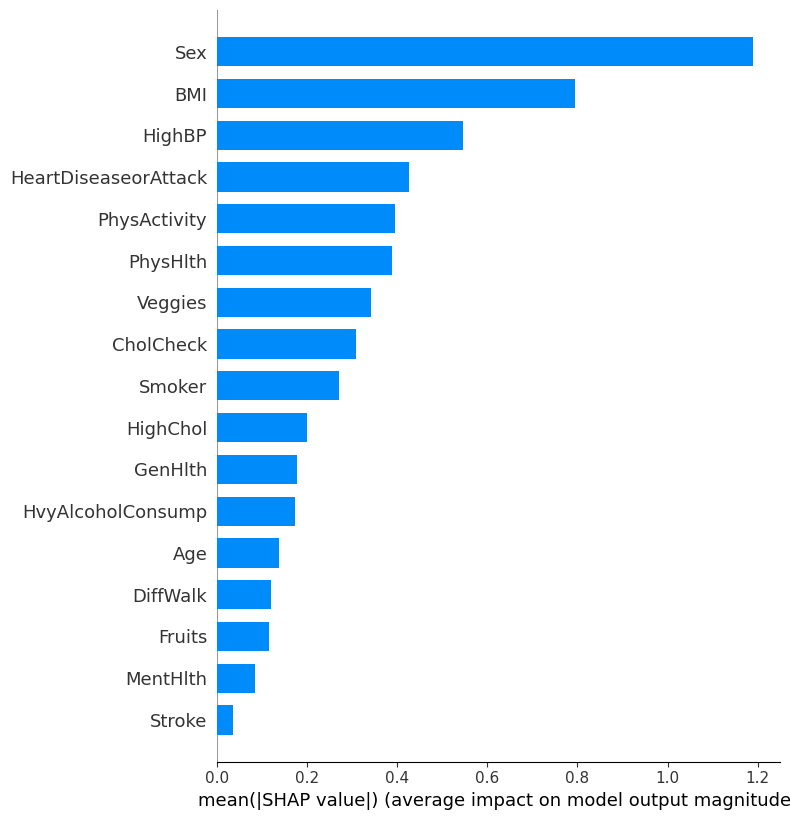

In [ ]:
# Aporte global
shap.summary_plot(shap_values, X, plot_type = "bar")

**¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?**

Se tiene que las conclusiones generadas de forma global indican qué tan importantes es una variable para hacer la clasificación, independiente de si su contribución es positiva o negativa. Además, se destaca que si bien una característica puede ser relevante de forma global, no tiene porqué tener una gran contribución para todas las instancias individualemnte. Este es el caso de Sex, la variable más relevante según el summary_plot no tiene una magnitud elevada para las instancias analizadas (1, 9 y 150).  



### Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [ ]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

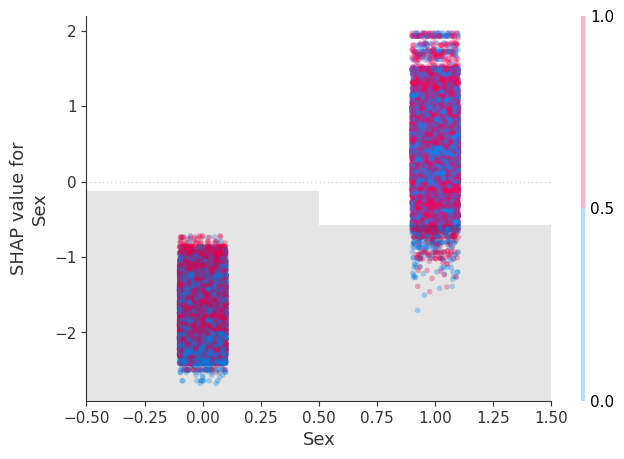

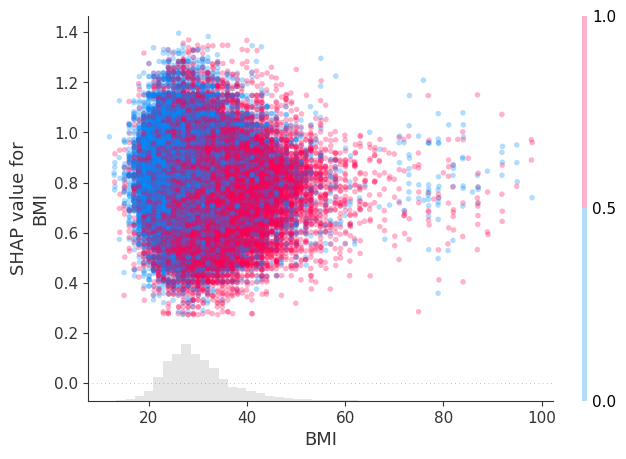

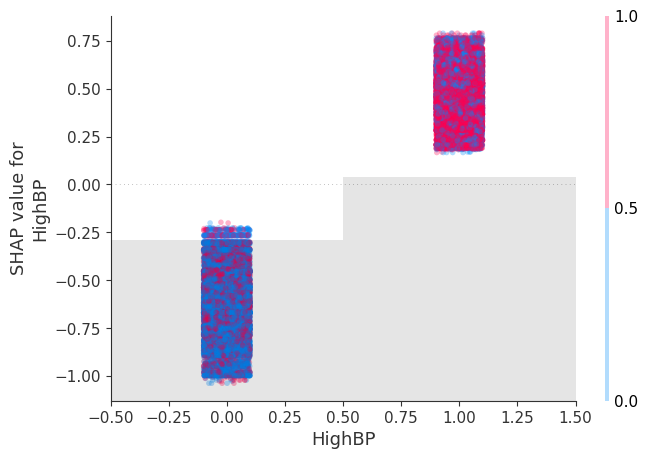

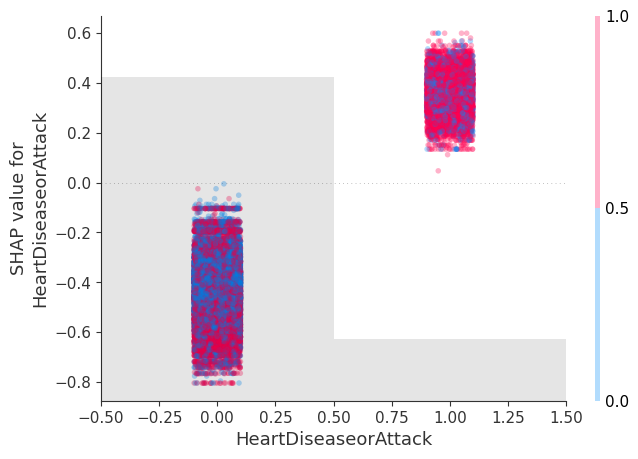

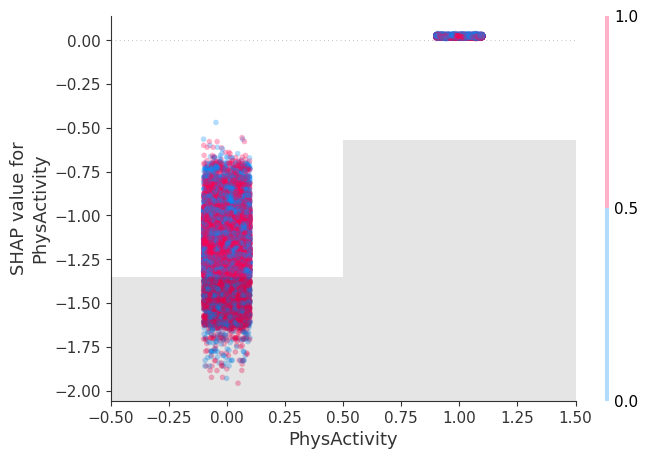

In [ ]:
# Scatter Plot
for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:, name], color=df.Diabetes.values, alpha=0.3)
    print('')


**¿Qué puede concluir de sus resultados?**

Se concluye que en la variable HighBP, los pacientes con alta presión sanguínea presentan una mayor probabilidad de tener diabetes lo cual se ve reflejado en los shap values. Para el resto de variables no hay una clara relación entre el signo/magnitud del shap value y la probabilidad de una persona de padecer diabetes.

### Parte E (0.4 pt)

\Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

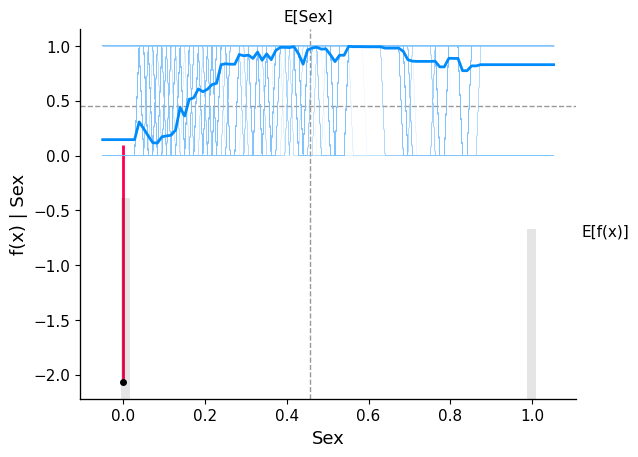

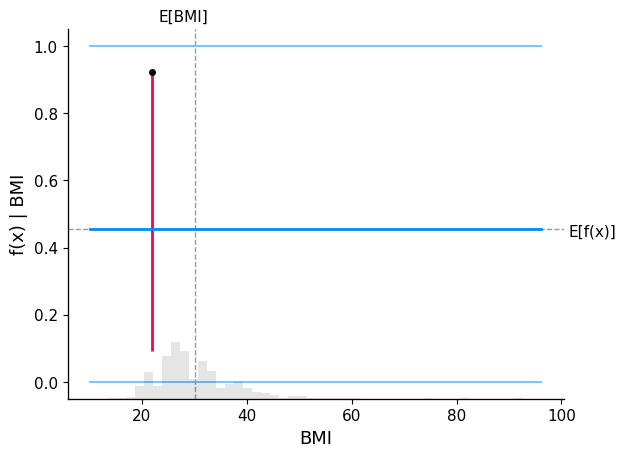

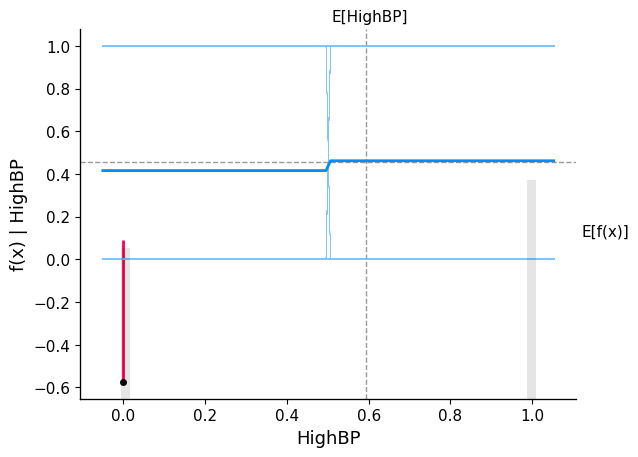

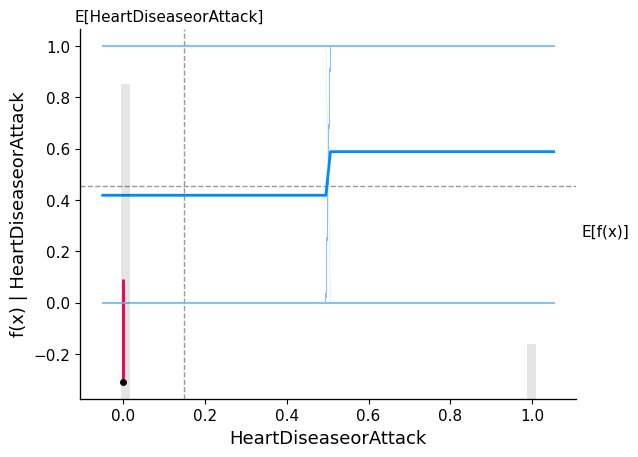

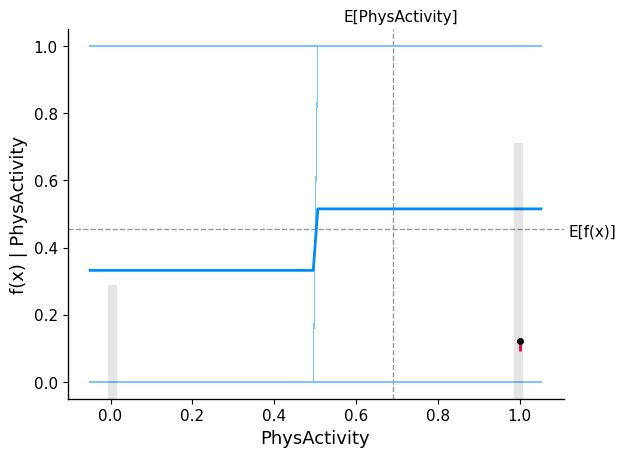

In [ ]:
X1000 = shap.utils.sample(X, 1000)
features = ['Sex', 'BMI', 'HighBP', 'HeartDiseaseorAttack', 'PhysActivity']
sample_ind = 20

for i in range(5):
  shap.partial_dependence_plot(features[i], pipeline.named_steps['classifier'].predict,
                            X1000, model_expected_value = True,
                            feature_expected_value = True, ice = True,
                            shap_values=shap_values[sample_ind:sample_ind+1,:]
                            )

**¿Qué relación existe entre la salida promedio del modelo y cada feature analizada?**

Con respecto a los PDP se comenta que al pertenecer a la clase 1 en las variables Sex, HighBP, HeartDiseaseAttack y PhysActivity aumenta la esperanza de la función f(x), lo que indica que aumenta la probabilidad de padecer diabetes.

Con respecto a la variable BMI se comenta que no presenta cambios en su esperanza al aumentar el valor de BMI, lo cual no coincide con lo esperado teóricamente.


**¿Son estas conclusiones generalizables para todo el conjunto de datos?**

Si bien tenemos que los PDP entregan conclusiones generalizales para la muestra de 1000 pacientes, no es posible garantizar que los resultados serán geralizables para los datos que no fueron utilizados para los PDP. En esta línea, si bien es posible que una muestra de 1000 datos tenga distribuciones similares a la poblacional, no se puede hablar de causalidad fuera de la muestra.

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
print(pipeline.named_steps['preprocessor'].feature_names_in_)

['Age' 'Sex' 'HighChol' 'CholCheck' 'BMI' 'Smoker' 'HeartDiseaseorAttack'
 'PhysActivity' 'Fruits' 'Veggies' 'HvyAlcoholConsump' 'GenHlth'
 'MentHlth' 'PhysHlth' 'DiffWalk' 'Stroke' 'HighBP']


In [ ]:
# Sistema de reglas
predict_fn = lambda x: pipeline.named_steps['classifier'].predict(x)
explainer = AnchorTabular(predict_fn,
                          pipeline.named_steps['preprocessor'].feature_names_in_,
                          seed = 1)
explainer.fit(X_train.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.3'}
)

In [ ]:
class_names = ["sin diabetes", "con diabetes"]

In [ ]:
idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  sin diabetes
Anchor: Sex <= 0.00 AND PhysActivity <= 0.00 AND HeartDiseaseorAttack <= 0.00
Precision: 1.00
Coverage: 0.15


In [ ]:
idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  con diabetes
Anchor: Sex > 0.00 AND HighChol <= 0.00
Precision: 0.95
Coverage: 0.21


In [ ]:
idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  con diabetes
Anchor: Sex > 0.00 AND Smoker <= 0.00 AND PhysActivity > 0.00
Precision: 0.98
Coverage: 0.15


**Con las reglas propuestas señale a cuánta población es posible explicar con estas reglas e indique la precisión que poseen las reglas en la totalidad de los datos.**

Para ver la proporsción de la población que puede afectar las reglas se observa la cobertura de estas, la cual corresponde a 0.19, 0.21 y 0.15 respectivamente.
Con respecto a la precisión alcanzada, se obtienen valores de 0.96, 0.95 y 0.98 respectivamente. Si bien la cobertura de los sistemas de reglas es baja, se alcanzan buenos resultados en la precisión.

**¿Tienen sentido sus reglas propuestas para las observaciones?**

En este caso, al ser variables binarias la segmentación tiene sentido. Con respecto a las predicciones obtenidas, se obtuvo que estas coinciden con los resultados de los PDP, ya que cuando las variables toman un valor igual a 1 se concideran como factores de riesgo y a las personas se les pronostica con diabetes.

# Retrospectiva... (1 pt)

**En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes.**

Con respecto a los sistemas de reglas se comenta que, en este caso, se obtuvieron modelos poco generalizables al tener baja cobertura (menor al 25%) por lo cual fueron descartados. No se recomienda el partial dependence plot ya que se puede graficar un número acotado de variables, pudiendo dejar de lado aspectos relevantes para el análisis.

Si el tiempo de procesamiento no es un problema, los shap values pueden ser una buena opción ya que ofrecen una interpretación individualizada y específica para cada paciente. De esta forma, se puede comprender cómo cada variable contribuye a la clasificación de cada paciente en particular. Además, los valores SHAP también permiten una visión general del impacto de las variables en el conjunto de datos completo.

Por otro lado, si se busca un modelo con menores tiempos de procesamiento, permutation feature importance puede ser una buena opción. Una de las principales ventajas de este método es que no asume que las variables son independientes o que están decorrelacionadas. Si bien este método puede verse alterado al ingresar variables con alta correlación, esto puede solucionarse haciendo un filtrado previo de características.

**¿Qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?**

Los métodos agnósticos locales se centran en la interpretación a nivel de instancia o de un subconjunto de instancias en particular. Estos métodos evalúan el impacto de las variables en la clasificación de cada una de las  instancisa, lo que puede ser útil para comprender cómo se toman decisiones en casos específicos. Sin embargo, pueden pasar por alto patrones globales una visión general del impacto de las variables en todo el conjunto de datos.

Por otro lado, los métodos agnósticos globales consideran el impacto promedio de las variables en todas las instancias del conjunto de datos, proporcionando una visión general del impacto de las variables en la clasificación en todo el conjunto de datos y pudiendo revelar patrones globales importantes. También pueden ser útiles para identificar las variables más relevantes en general.

Si el doctor Simi está interesado en comprender cómo se toman decisiones en casos individuales se considera que los métodos agnósticos locales pueden ser más adecuados. Por otro lado, si prefiere una comprensión más general del impacto de las variables en la clasificación de los pacientes con diabetes, los métodos agnósticos globales pueden ser más apropiados.



Con respecto a los sistemas de reglas se comenta que, en este caso, se obtuvieron modelos poco generalizables al tener baja cobertura (menor al 25%) por lo cual fueron descartados.

Los shap values no se recomiendan ya que, por un lado, tienen un gran tiempo de compilado y asume que las variables están decorrelacionadas. Si bien esta permite generar explicaciones locales frente a los

No se recomienda el partial dependence plot ya que se puede graficar un número acotado de variables, pudiendo dejar de lado variables relevantes para el análisis.

Globales: permutation

Los permutation feature importance se consideran adecuados, ya que no asumen que las variables son independientes o que están decorrelacionadas. Si bien este método puede verse alterado al ingresar variables con alta correlación, esto puede solucionarse haciendo un filtrado previo de características.



# Conclusión

Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>